<a href="https://colab.research.google.com/github/kimys0279/NCSU/blob/main/HOML/HOML_Ch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install google-colab 
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [2]:
import os
import tarfile
import urllib

HOUSING_PATH = "/content/gdrive/MyDrive/Work/HOML/cal_housing/CaliforniaHousing"

In [3]:
import pandas as pd

def load_housing_data(housing_path = HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'cal_housing.data')
  return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()
housing.columns = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
1,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
2,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
3,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
4,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0


In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20639 entries, 0 to 20638
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20639 non-null  float64
 1   latitude            20639 non-null  float64
 2   housing_median_age  20639 non-null  float64
 3   total_rooms         20639 non-null  float64
 4   total_bedrooms      20639 non-null  float64
 5   population          20639 non-null  float64
 6   households          20639 non-null  float64
 7   median_income       20639 non-null  float64
 8   median_house_value  20639 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000,20639.000000
mean,-119.569576,35.631753,28.638888,2635.848152,537.917825,1425.530210,499.557779,3.870455,206843.910122
std,2.003495,2.135947,12.585568,2181.633870,421.248495,1132.463507,382.330173,1.899615,115385.731702
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1448.000000,295.500000,787.000000,280.000000,2.563100,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534700,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.742850,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


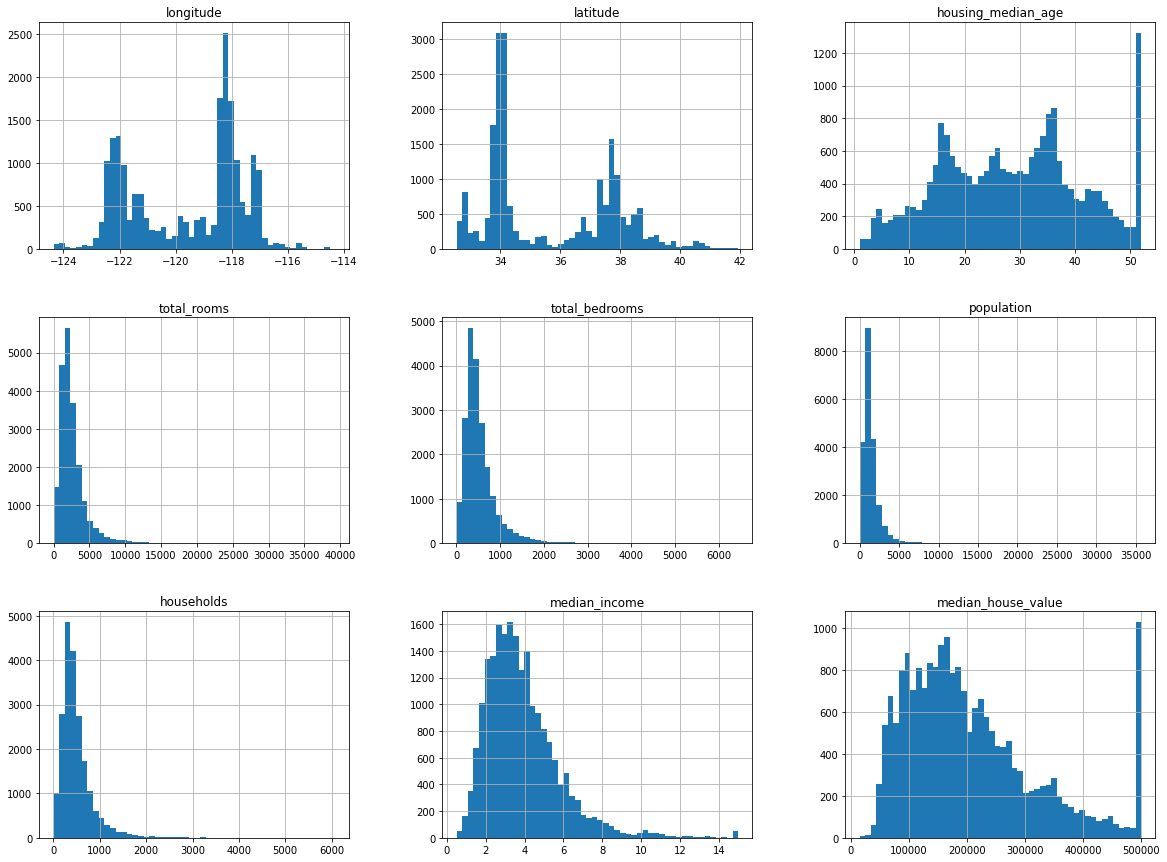

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins = 50, figsize = (20, 15))
plt.show()

In [8]:
import numpy as np
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set), len(test_set)

(16512, 4127)

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2*32

In [11]:
def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [13]:
housing_with_id['id'] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [14]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1, 2, 3, 4, 5])

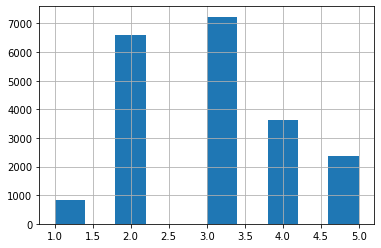

In [16]:
housing["income_cat"].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [19]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis = 1, inplace = True)

In [20]:
housing = strat_train_set.copy()

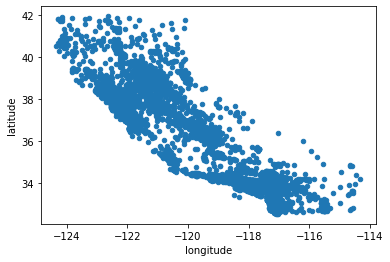

In [21]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude")

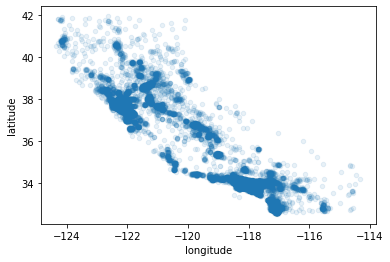

In [22]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

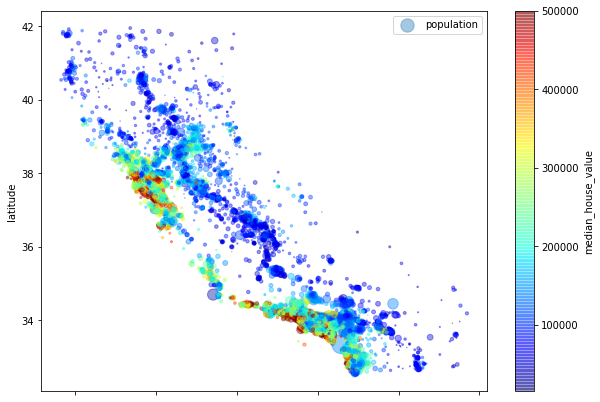

In [23]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, s = housing["population"]/100, label = "population", figsize = (10, 7), c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

In [24]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.686517
total_rooms           0.133428
housing_median_age    0.114278
households            0.064884
total_bedrooms        0.048706
population           -0.025649
longitude            -0.046732
latitude             -0.143246
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e748c3810>,
      dtype=object)

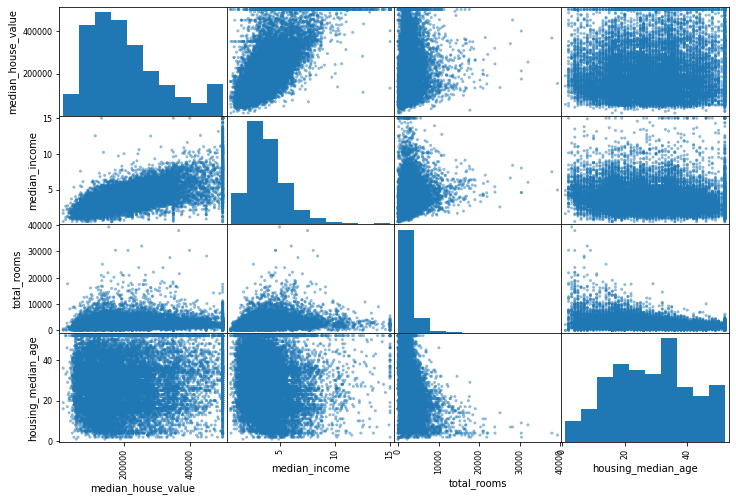

In [25]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12, 8))

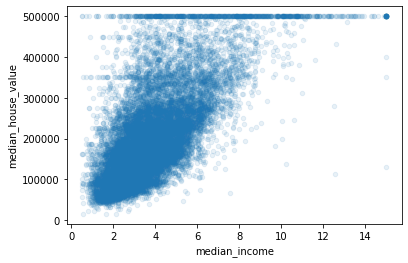

In [26]:
housing.plot(kind = "scatter", x = "median_income", y = "median_house_value", alpha = 0.1)

In [27]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [28]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.686517
rooms_per_household         0.144192
total_rooms                 0.133428
housing_median_age          0.114278
households                  0.064884
total_bedrooms              0.048706
population_per_household   -0.021751
population                 -0.025649
longitude                  -0.046732
latitude                   -0.143246
bedrooms_per_room          -0.258994
Name: median_house_value, dtype: float64

In [29]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

In [30]:
housing.dropna(subset = ["total_bedrooms"])
housing.drop("total_bedrooms", axis = 1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace = True)

In [31]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")

In [32]:
housing_num = housing
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [33]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.    ,  433.    , 1164.    ,
        408.    ,    3.5414])

In [34]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.    ,  433.    , 1164.    ,
        408.    ,    3.5414])

In [35]:
X = imputer.transform(housing_num)

In [37]:
housing_tr = pd.DataFrame(X, columns = housing_num.columns, index = housing_num.index)